In [1]:
cd dataset

C:\Users\Miya\Desktop\cna\dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('repositories_refined.csv',parse_dates=['Month, Day, Year of Date'])
#data = data[data['Coding Effort']!=0]
data.columns= ['Worker ID','Repository ID','Coding Effort','Month, Day, Year of Date']

In [3]:
data.head()

,Worker ID,Repository ID,Coding Effort,"Month, Day, Year of Date"
0,aaa,AAA,0.00,2015-07-01
1,dxw,HEL,5.00,2015-07-01
2,woe,WHS,4.73,2015-07-01
3,woe,EZR,0.26,2015-07-01
4,wlk,RJA,5.00,2015-07-01


In [4]:
np.min(data.groupby(['Worker ID']).transform(lambda x: x - x.mean()).values)

-4.9227941176470589

In [5]:
X_test = data[data['Month, Day, Year of Date']>='2015-07-08']
X_train = data[data['Month, Day, Year of Date']<'2015-07-08']

X_train['Coding Effort'] = X_train.groupby(['Worker ID']).transform(lambda x: x - x.mean()+5).values

In [6]:
def dirty_model():
    pred_base = []
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    for deve in to_predict_deve:
        old = tp[tp['Worker ID']==deve]['Repository ID']
        new = [i for i in Most_popu_repo if i not in old]
    pred_base.append(new)
    
    return pred_base

In [7]:
Most_popu_repo = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby('Repository ID').count().sort_values('Worker ID',ascending = False).index

In [8]:
print(X_train.shape)
print(X_test.shape)

(13155, 4)
(159199, 4)


In [9]:
deve_nodes_train = list(set(X_train.values[:,0]))
deve_nodes_test = list(set(X_test.values[:,0]))

In [10]:
X_test = X_test[X_test['Worker ID'].isin([test for test in deve_nodes_test if test in deve_nodes_train])]

In [11]:
X_test = X_test.groupby(['Worker ID','Repository ID']).sum().reset_index()

In [12]:
t1 = pd.DataFrame(X_train['Worker ID']+X_train['Repository ID'],columns = ['temp'])
t2 = pd.DataFrame(X_test['Worker ID']+X_test['Repository ID'],columns = ['temp'])

In [13]:
X_test = X_test[~t2['temp'].isin(t1['temp'])]

In [14]:
sum(pd.DataFrame(X_test["Worker ID"]+X_test["Repository ID"])[0].isin(t1['temp']))

0

In [15]:
X_test.shape

(2775, 3)

In [16]:
len(list(set(X_test.values[:,0])))

945

In [17]:
len(list(set(X_train.values[:,0])))

2321

In [18]:
X_train = X_train.groupby(['Worker ID','Repository ID']).sum().reset_index().values

In [19]:
X_test.shape[0]/X_train.shape[0]

0.8748423707440101

In [20]:
np.max(X_test.groupby('Worker ID').count().values[:,0])

33

In [21]:
len(set(list(X_train[:,1])))

921

In [22]:
actual_list = []
to_predict_deve = set(X_test['Worker ID'])
print(len(to_predict_deve))
for dev in to_predict_deve:
    repo = X_test[X_test['Worker ID']==dev].sort_values('Coding Effort')['Repository ID'].values
    actual_list.append(list(repo))

945


In [23]:
import networkx as nx
%matplotlib inline
from networkx.algorithms import bipartite
G_train = nx.Graph()
for i,v,j in zip(X_train[:,0],X_train[:,1],X_train[:,2]):
    G_train.add_edge(i,v,weight = j)

In [24]:
nx.write_gml(G_train,'g_2.gml')

In [25]:
X_train.shape

(3172, 3)

In [26]:
X_test.shape

(2775, 3)

In [27]:
method = 'binary' #binary, my_weight, jaccard, manhattan
deve_nodes = list(set(X_train[:,0]))

In [28]:
def normalize(x):
    if x==0:
        x = 1
    else:
        x
    return x

def my_weight(G_train, u, v, weight='weight'):
    w = 0
    for nbr in set(G_train[u]) & set(G_train[v]):
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        nbr_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[nbr].values()))))
        
        trans = (G_train.edge[u][nbr].get(weight,0)/u_sum) * (G_train.edge[v][nbr].get(weight,0)/nbr_sum)        
        w += trans
        return w 
    
def jaccard(G, u, v): # jaccard similar
    unbrs = set(G[u])
    vnbrs = set(G[v])
    return float(len(unbrs & vnbrs)) / len(unbrs)

def manhattan(G,u,v,weight='weight'): ## Euclidean similar
    
    for nbr in set(G_train[u]) & set(G_train[v]):
        
        w = []
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        a = G_train.edge[u][nbr].get(weight,0)/u_sum
        b = G_train.edge[v][nbr].get(weight,0)/v_sum
        w.append(np.sqrt(np.power(a-b,2)))
                 
        return np.mean(w)

In [29]:
def project_graph(G_train,method = method):
    
    if method =='binary':
        graph = nx.projected_graph(G_train,deve_nodes)
    if method == 'my_weight':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= my_weight)
        graph = nx.Graph(graph) 
    if method == 'jaccard':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= jaccard)
        graph = nx.Graph(graph) 
    if method == 'manhattan':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= manhattan)
        graph = nx.Graph(graph)

    return graph

for m in ['binary','my_weight','jaccard','manhattan']:
    graph = project_graph(G_train,method = m)
    nx.write_gml(graph,m+'.gml')

In [30]:
import itertools
def neighbors_cluster(node, method = method ):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes')    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    #kmeans = refer.ix[node,5]
    spherical = refer.ix[node,5]
    tied = refer.ix[node,6]
    diag = refer.ix[node,7]
    full = refer.ix[node,8]

    ml_nn = refer[refer['ml_member']==ml].index
    ml_nn = [n for n in ml_nn if n != node]
    
    wt_nn = refer[refer['wt_member']==wt].index
    wt_nn = [n for n in wt_nn if n != node]

    info_nn = refer[refer['info_member']==info].index
    info_nn = [n for n in info_nn if n != node]

    fg_nn = refer[refer['fg_member']==fg].index
    fg_nn = [n for n in ml_nn if n != node]

    lp_nn = refer[refer['lp_member']==lp].index
    lp_nn = [n for n in lp_nn if n != node]

    #kmeans_nn = refer[refer['kmeans']==kmeans].index
    spherical_nn = refer[refer['gmmspherical']==spherical].index
    spherical_nn = [n for n in spherical_nn if n != node]

    tied_nn = refer[refer['gmmtied']==tied].index
    tied_nn = [n for n in tied_nn if n != node]

    diag_nn = refer[refer['gmmdiag']==diag].index
    diag_nn = [n for n in diag_nn if n != node]

    full_nn = refer[refer['gmmfull']==full].index
    full_nn = [n for n in full_nn if n != node]

    
    cluster_nn = list(itertools.chain(wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn)) #ml_nn,info_nn
    
    return cluster_nn

In [31]:
def neighbors_cluster_weighted(node, method = 'binary'):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes') 
    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    #kmeans = refer.ix[node,5]
    spherical = refer.ix[node,5]
    tied = refer.ix[node,6]
    diag = refer.ix[node,7]
    full = refer.ix[node,8]
    
    ml_nn = refer[refer['ml_member']==ml].index
    ml_nn = [n for n in ml_nn if n != node]
    
    wt_nn = refer[refer['wt_member']==wt].index
    wt_nn = [n for n in wt_nn if n != node]

    info_nn = refer[refer['info_member']==info].index
    info_nn = [n for n in info_nn if n != node]

    fg_nn = refer[refer['fg_member']==fg].index
    fg_nn = [n for n in ml_nn if n != node]

    lp_nn = refer[refer['lp_member']==lp].index
    lp_nn = [n for n in lp_nn if n != node]

    #kmeans_nn = refer[refer['kmeans']==kmeans].index
    spherical_nn = refer[refer['gmmspherical']==spherical].index
    spherical_nn = [n for n in spherical_nn if n != node]

    tied_nn = refer[refer['gmmtied']==tied].index
    tied_nn = [n for n in tied_nn if n != node]

    diag_nn = refer[refer['gmmdiag']==diag].index
    diag_nn = [n for n in diag_nn if n != node]

    full_nn = refer[refer['gmmfull']==full].index
    full_nn = [n for n in full_nn if n != node]
    

    
    return wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn

In [32]:
K = 100
def limit_k(rs_list, k = K):
    if len(rs_list)<k:
        return rs_list
    else:
        return rs_list[:k]  

In [33]:
def ensemble_similarity(node,wf):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node,method = method)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we

        
    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*1
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [34]:
def community_weight(method = method):
    
    df = pd.read_csv(method +'.csv').set_index('nodes')
    wt_w = len(df['wt_member'].unique())/100
    ml_w = len(df['ml_member'].unique())/100
    info_w = len(df['info_member'].unique())/100
    fg_w = len(df['fg_member'].unique())/100
    lp_w = len(df['lp_member'].unique())/100
    
    wt_w =  np.sqrt((wt_w))
    ml_w =  np.sqrt((ml_w))
    info_w = np.sqrt(info_w)
    fg_w = np.sqrt(fg_w)
    lp_w = np.sqrt(lp_w)
    
    return wt_w,ml_w,info_w,fg_w,lp_w

In [35]:
def cluster_weight():
    
    spherical = gmm_clusters['spherical']/100
    full = gmm_clusters['full']/100
    diag = gmm_clusters['diag']/100
    tied = gmm_clusters['tied']/100
    
    spherical =  np.sqrt(spherical)
    full =  np.sqrt(full)
    diag = np.sqrt(diag)
    tied = np.sqrt(tied)    

    
    return spherical,full, diag, tied

In [36]:
def ensemble_similarity_weighted(node,wf,method = method):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn = neighbors_cluster_weighted(node, method = method)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
    
    spherical,full, diag, tied = cluster_weight()
     
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we
        
    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
                     
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
            
    for nn in spherical_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*spherical
    for nn in tied_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*tied
    for nn in diag_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*diag
    for nn in full_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*full
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [37]:
def projection_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    dict_rs = dict()
        
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [38]:
def cluster_similarity(node):
    
    dict_rs = dict()
    cluster_nn = neighbors_cluster(node, method = method)

    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [39]:
def f2(seq): 
    checked = []
    for e in seq:
        if e not in checked:
            checked.append(e)
    return checked

In [40]:
def cluster_similarity_weighted(node):
    
    dict_rs = dict()
    
    wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn = neighbors_cluster_weighted(node, method = method)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
    spherical,full, diag, tied = cluster_weight()


    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w

    for nn in spherical_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*spherical
    for nn in tied_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*tied
    for nn in diag_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = (repo_sug[1]['weight'])
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*diag
    for nn in full_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*full
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [41]:
def accuracy(actual, predicted, k= K):
    if len(predicted)>k:
        predicted = predicted[:k]
    
    eva = [p for p in predicted if p in actual]
    
    if len(eva)!=0:
        score  = 1
    else:
        score = 0 

    return score 

def accuracy_mean(actual_list, predicted_list, k= K):

    return np.mean([accuracy(a,p,k) for a,p in zip(actual_list, predicted_list)])
    

In [42]:
def recall(actual, predicted, k= K):
    if len(predicted)>k:
        predicted = predicted[:k]
    
    eva = [p for p in predicted if p in actual]
    

    return len(eva)/len(actual) 

def recall_mean(actual_list, predicted_list, k= K):

    return np.mean([recall(a,p,k) for a,p in zip(actual_list, predicted_list)])
    

In [43]:
def apk(actual, predicted, k= K):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k= K):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
            
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual_list, predicted_list)])

In [44]:
def similarity_rs(node_list, choice = "projection_similarity",wf = my_weight):
    
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    
    dict_rs = dict()
    
    for node in node_list:
        if choice == 'projection_similarity':
             rs_list = projection_similarity(node,wf)
        if choice == 'cluster_similarity':
             rs_list = cluster_similarity(node)
        if choice == 'cluster_similarity_weighted':
             rs_list = cluster_similarity_weighted(node)
        if choice == 'ensemble_similarity_weighted':
             rs_list = ensemble_similarity_weighted(node,wf)
        if choice == 'ensemble_similarity_weighted_half':
            rs_list=[]
            rs_list1 = cluster_similarity_weighted(node)
            rs_list2 = projection_similarity(node,wf)
            for p, sw in zip(rs_list2, rs_list1):
                rs_list.append(p)
                rs_list.append(sw)
            rs_list = limit_k(list(set(rs_list)),k=100)
        if choice == 'projection_ensemble':
            rs_list=[]
            rs_list1 = projection_similarity(node,wf=my_weight)
            rs_list2 = projection_similarity(node,wf=manhattan)
            rs_list3 = projection_similarity(node,wf=jaccard)
            for m,w,j in zip(rs_list2, rs_list1,rs_list3):
                rs_list.append(m)
                rs_list.append(w)
                rs_list.append(j)
            rs_list = limit_k(f2(rs_list),k=100)

        old = tp[tp['Worker ID']==node]['Repository ID']
        
        rs_list = [i for i in rs_list if i not in old]
            
    
        dict_rs[node] = rs_list
    
    return dict_rs

**Base Model:** binary projection + cluster + community detection

** Models:** 
* my_weight projection 
* jaccard projection
* my_weight projection + cluster 
* jaccard projection + cluster 
* my_weight projection + cluster weighted 
* jaccard projection + cluster weighted


In [45]:
top_K = 10

In [46]:
available = list(set(X_train[:,1]))

for i in actual_list:
    for j in i:
        if j not in available:
            i.remove(j)
effect_index = []
for m,n in enumerate(actual_list):
    if len(n)!=0:
        effect_index.append(m)

actual_reduced = np.asarray(actual_list)[effect_index]     

def reduce(x):
    return np.asarray(list(x))[effect_index]   

# baseline model

In [47]:
method = 'binary'

y_predict_dict_c = similarity_rs(to_predict_deve, choice = "cluster_similarity",wf = my_weight)

In [48]:
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_c.values()), k=  top_K))
print(mapk(actual_reduced,reduce(y_predict_dict_c.values()), k=  top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_c.values()), k=  top_K))

0.434466019417
0.148393476896
0.328149367646


# Weighted Projection

In [52]:
y_predict_dict_p = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = my_weight)
y_predict_dict_p_j = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = jaccard)
y_predict_dict_p_m = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = manhattan)
y_predict_dict_p_e = similarity_rs(to_predict_deve, choice = "projection_ensemble",wf = my_weight)

In [53]:
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_p.values()), k=  top_K))
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_p_j.values()), k=  top_K))
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_p_m.values()), k=  top_K))
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_p_e.values()), k=  top_K))
print('----')
print(mapk(actual_reduced, reduce(y_predict_dict_p.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_p_j.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_p_m.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_p_e.values()), k=  top_K))
print('----')
print(recall_mean(actual_reduced, reduce(y_predict_dict_p.values()), k=  top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_p_j.values()), k=  top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_p_m.values()), k=  top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_p_e.values()), k=  top_K))

0.586165048544
0.580097087379
0.578883495146
0.584951456311
----
0.197101025438
0.19328409364
0.220819216991
0.223242311431
----
0.459226912853
0.451760628126
0.450488764202
0.454684369703


In [54]:
np.mean(list(filter(lambda x:x!=0,[apk(a,p,10) for a,p in zip(actual_reduced, reduce(y_predict_dict_p_e.values()))])))

0.38164245771691191

In [55]:
np.sum(list(map(lambda x:x==1,[apk(a,p,10) for a,p in zip(actual_reduced, reduce(y_predict_dict_p_e.values()))])))

58

# My Weight 

In [56]:
method = 'my_weight'

y_predict_dict_c_w = similarity_rs(to_predict_deve, choice = "cluster_similarity_weighted",wf = my_weight)
y_predict_dict_e_w = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted",wf = my_weight)
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted_half",wf = my_weight)

In [57]:
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_c_w.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_c_w.values()), k= top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_c_w.values()), k= top_K))
print('---')
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_e_w.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_e_w.values()), k= top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_e_w.values()), k= top_K))
print('---') 
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_e_w_h.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_e_w_h.values()), k= top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_e_w_h.values()), k= top_K))

0.470873786408
0.17223697437
0.355538506959
---
0.484223300971
0.18083348144
0.364389061744
---
0.547330097087
0.204216729448
0.414662619608


In [58]:
y_predict_dict_all = dict()

for node in to_predict_deve:
    
    list1 = y_predict_dict_c_w[node]
    list2 = y_predict_dict_p_e[node]
    for i in list1:
        list2.append(i)

    y_predict_dict_all[node] = f2(list2)

In [59]:
print(accuracy_mean(actual_reduced, reduce(y_predict_dict_all.values()), k=  top_K))
print(mapk(actual_reduced, reduce(y_predict_dict_all.values()), k= top_K))
print(recall_mean(actual_reduced, reduce(y_predict_dict_all.values()), k= top_K))

0.597087378641
0.227328376953
0.467640061688


In [60]:
len(actual_reduced)

824

In [61]:
sum(list(map(lambda x:len(x)==1,actual_reduced)))

467

In [62]:
len(X_test['Repository ID'].unique())

1240

In [63]:
len(set(X_train[:,1]))

921

In [49]:
## R run associated graph
    
def generate_communities(method = method):
    
    print(method)
    
    wt = pd.read_csv('wt_df.csv')
    wt.columns = ['wt_member','nodes']
    ml = pd.read_csv('ml_df.csv')
    ml.columns = ['ml_member','nodes']

    info = pd.read_csv('info_df.csv')
    info.columns = ['info_member','nodes']

    fg = pd.read_csv('fg_df.csv')
    fg.columns = ['fg_member','nodes']

    lp = pd.read_csv('lp_df.csv')
    lp.columns = ['lp_member','nodes']
    
    temp = pd.merge(ml,info, how='inner', on='nodes')
    temp = pd.merge(temp,wt, how='inner', on='nodes')
    temp = pd.merge(temp,fg, how='inner', on='nodes')
    temp = pd.merge(temp,lp, how='inner', on='nodes')
    
    graph = project_graph(G_train,method = method)
    
    
    degree_df = pd.DataFrame.from_dict({'nodes':list(nx.degree(graph).keys()),'Degree':list(nx.degree(graph).values())})
    betweenness_df = pd.DataFrame({'between':list(nx.betweenness_centrality(graph).values())})
    close_df = pd.DataFrame({'close':list(nx.closeness_centrality(graph).values())})
    eigen_df = pd.DataFrame({'eigen':list(nx.eigenvector_centrality_numpy(graph).values())})
    pager_df = pd.DataFrame({'pagerank':list(nx.pagerank(graph).values())})

    temp2 = pd.concat([degree_df,betweenness_df,close_df,eigen_df,pager_df],axis = 1,join = 'inner')
    temp2 = temp2[temp2['nodes'].isin(deve_nodes)].set_index('nodes')
    
    
    return temp, temp2

In [50]:
## R run associated graph

method = 'my_weight' # my_weight, jaccard,binary,manhattan

temp, temp2 = generate_communities(method = method)
X_kmeans = temp2.values

my_weight


In [51]:
from sklearn import mixture
n_components_range = range(1, 100)

cts = ['spherical', 'tied', 'diag', 'full']
dict_gmm = dict()

gmm_clusters = {}

for ct in cts:
    bic = []
    lowest_bic = np.infty
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type=ct)
        
        gmm.fit(X_kmeans)
        bic.append(gmm.bic(X_kmeans))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm  = gmm
    print(lowest_bic)
    print(best_gmm)
    gmm_clusters[ct] = best_gmm.n_components
    gmm_df = pd.DataFrame(np.asarray([temp2.index, best_gmm.predict(X_kmeans)]).T,columns = ['nodes','gmm'+ct])
    temp = pd.merge(temp,gmm_df, how='inner', on='nodes')
    
assign_all = temp.set_index('nodes')
assign_all.to_csv(method+'.csv')

-113832.998231
GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=95, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)
-114143.404233
GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=96, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
-112850.670162
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=77, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
-107022.566555
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
     

In [99]:
n_clusters= 20
kmeans = KMeans(n_clusters= n_clusters).fit(X_kmeans)
kmeans_assign = kmeans.labels_
kmeans_df = pd.DataFrame(np.asarray([temp2.index, kmeans_assign]).T,columns = ['nodes','kmeans'])

In [100]:
sum(list(map(lambda x:x.lower()!=x,to_predict_deve)))

0

In [97]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1,100)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_kmeans)
    kmeanModel.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X_kmeans.shape[0])

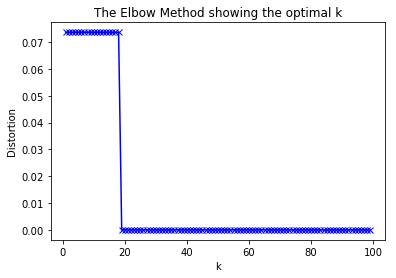

In [98]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow'+method+'.png')

In [330]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=20, verbose=2).fit_transform(X_kmeans)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2321 samples in 0.001s...
[t-SNE] Computed neighbors for 2321 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2321
[t-SNE] Computed conditional probabilities for sample 2000 / 2321
[t-SNE] Computed conditional probabilities for sample 2321 / 2321
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.444s
[t-SNE] Iteration 50: error = 65.0737839, gradient norm = 0.0784026 (50 iterations in 3.001s)
[t-SNE] Iteration 100: error = 54.1281204, gradient norm = 0.0433606 (50 iterations in 2.012s)
[t-SNE] Iteration 150: error = 50.8491364, gradient norm = 0.0328969 (50 iterations in 1.833s)
[t-SNE] Iteration 200: error = 49.1697311, gradient norm = 0.0271565 (50 iterations in 1.800s)
[t-SNE] Iteration 250: error = 48.1040573, gradient norm = 0.0239064 (50 iterations in 1.784s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.104057
[t-SNE] Iteration 300: erro

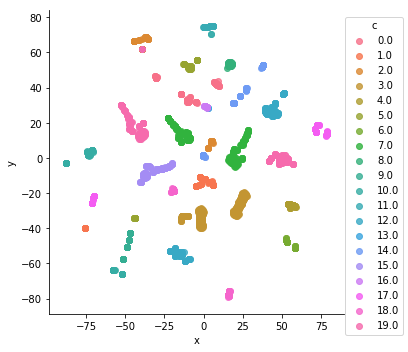

In [331]:
import seaborn as sns
tsne_df = pd.DataFrame(np.append(X_tsne.T,[kmeans_assign],0).T,columns = ['x','y','c'])
sns.lmplot('x', 'y',data = tsne_df, hue='c',size = 5,fit_reg = False)

In [153]:
gmm_clusters

{'diag': 75, 'full': 74, 'spherical': 96, 'tied': 97}

In [154]:
assign_all.head()

,ml_member,info_member,wt_member,fg_member,lp_member,gmmspherical,gmmtied,gmmdiag,gmmfull
nodes,,,,,,,,,
zgw,75,92,232,101,1,88,58,18,15
hkv,170,76,102,105,2,66,87,63,61
rvv,207,2,3,33,3,11,1,3,27
euc,1,29,230,43,4,4,33,36,35
mou,58,3,23,83,5,3,3,10,7
